In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ephem
import math
from datetime import timedelta
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



In [99]:
import act 
import imagehash
from PIL import Image
import shutil
import pathlib as pl
import subprocess

token='7915e9fe3c987b12'

In [110]:
final_dest = pl.Path("/global/homes/r/rudisill/gshare2/will_data/radiation_timeseries/images_scratch/")
dest = pl.Path("/global/homes/r/rudisill/gshare2/will_data/radiation_timeseries/images_scratch/temp_folder")
dest2 = pl.Path("/global/homes/r/rudisill/gshare2/will_data/radiation_timeseries/images_scratch/temp_folder2")

dest.mkdir(parents=False, exist_ok=True)
dest2.mkdir(parents=False, exist_ok=True)



In [4]:
def untar_archive(archive_path, extract_path):
    try:
        subprocess.run(["tar", "-xf", archive_path, "-C", extract_path])
    except subprocess.CalledProcessError as e:
        print(f"Extraction failed with error: {e}")

#### get data 

In [100]:
def calculate_solar_cos_zenith(datetime_obj):
    observer = ephem.Observer()
    latitude  = 38.980762    # ERW
    longitude = -107.005017  # ERW
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = datetime_obj
    
    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude

    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

In [101]:
master_df = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv", index_col=0, parse_dates=True)                        

In [102]:
kolias = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/kollias/cbh_kolias2.nc").to_pandas()
cloud_present_kolias = kolias.copy()
cloud_present_kolias[cloud_present_kolias == -1] = 0
cloud_present_kolias[cloud_present_kolias > 0] = 1


kolias_lt_4000 = kolias.where(kolias < 6000)
kolias_lt_4000.fillna(-1, inplace=True)
cloud_present_kolias_lt_4000 = kolias_lt_4000.copy()
cloud_present_kolias_lt_4000[cloud_present_kolias_lt_4000 == -1] = 0
cloud_present_kolias_lt_4000[cloud_present_kolias_lt_4000 > 0] = 1

master_df['cloud_present'] = cloud_present_kolias_lt_4000.resample("1h").mean().reindex(master_df.index) * 100

In [103]:
master_df['hour'] = master_df.index.hour
master_df['month'] =master_df.index.month

In [104]:
master_df['cza'] = master_df.index.map(calculate_solar_cos_zenith)

In [105]:
master_df['cre_sw'] = master_df.qcrad_swd - master_df.rrtmg_swd_clear

### get image and make plot 

In [106]:
master_df['cre_lw'] =  master_df.qcrad_lwd - master_df.rrtmg_lwd_clear 

In [131]:
# sd = "2022-05-18"
# ed = "2022-05-19"

sd = "2022-05-11"
ed = "2022-05-13"


# sd = "2023-05-01"
# ed = "2023-05-02"


In [108]:
# def untar_archive(archive_path, extract_path):
#     try:
#         subprocess.run(["tar", "-xf", archive_path, "-C", extract_path])
#     except subprocess.CalledProcessError as e:
#         print(f"Extraction failed with error: {e}")

# output_file = act.discovery.download_data(
#     "willrudisill", token, "guccamgndradpirM1.a1", sd, ed, output=dest
# )


# for x in output_file:
#     untar_archive(x, dest)

In [132]:
def untar_archive(archive_path, extract_path):
    try:
        subprocess.run(["tar", "-xf", archive_path, "-C", extract_path])
    except subprocess.CalledProcessError as e:
        print(f"Extraction failed with error: {e}")

output_file = act.discovery.download_data(
    "willrudisill", token, "guccamweathermainS2.a1", sd, ed, output=dest
)


for x in output_file:
    untar_archive(x, dest)

[DOWNLOADING] guccamweathermainS2.a1.20220511.000100.jpg.tar
[DOWNLOADING] guccamweathermainS2.a1.20220512.000100.jpg.tar


In [15]:
# ### try the data downloader for tsi image...
# output_file = act.discovery.download_data(
#     "willrudisill", token, "guctsimovieM1.a1", sd, ed, output=dest
# )



In [133]:
d1 = "".join(sd.split("-"))
d2 = "".join(ed.split("-"))
files = list(sorted(dest.glob("*%s*.jpg"%d1))) + list(sorted(dest.glob("*%s*.jpg"%d2)))

In [134]:
def get_file_from_date(datetime):
    return list(dest.glob("guccamweathermain*%s*.jpg"%datetime.strftime("%Y%m%d.%H")))

#f=get_file_from_date(pd.to_datetime("2023-04-01 19"))


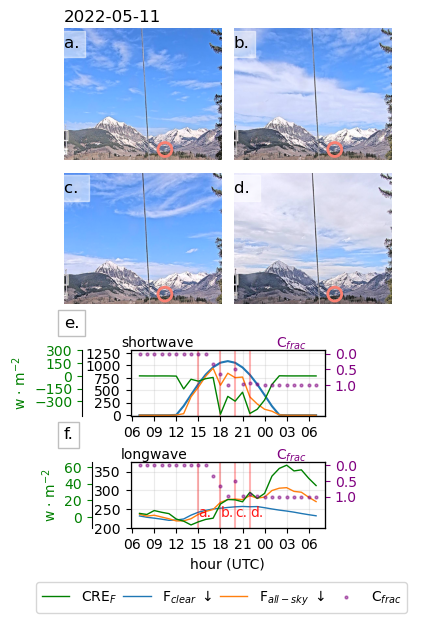

In [142]:
fig = plt.figure(figsize=([4.5,7]))
gs = gridspec.GridSpec(7, 5, width_ratios=[.6, 1, 1, .6, .1], height_ratios=[1, 1, .15, .5, .15, .5, .2])


ax1 = plt.subplot(gs[0,:2])
ax2 = plt.subplot(gs[0,2:-1])
ax3 = plt.subplot(gs[1,:2])
ax33 = plt.subplot(gs[1,2:-1])

axtxt1 = plt.subplot(gs[2,:])
axtxt2 = plt.subplot(gs[4,:])

ax4 = plt.subplot(gs[3,1:-2])
ax5 = plt.subplot(gs[5,1:-2])
axleg= plt.subplot(gs[6,:])


axtxt1.axis("off")
axtxt2.axis("off")
axleg.axis('off')


 
tx01 = axtxt1.text(0, .5, "e.", fontsize=12, color='black', transform=axtxt1.transAxes)
tx02 = axtxt2.text(0, .5, "f.", fontsize=12, color='black', transform=axtxt2.transAxes)
tx01.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='gray'))
tx02.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='gray'))

###########################
#sub = master_df["2022-04-25 07": "2022-04-26 07"]
sub = master_df[sd+" 07" : ed+" 07"]
dt = sub.index 



# label the top most image 


##### plot images 
##### plot the first image 
#i=120
#t1 = files[i]

sd = "2022-05-11"
ed = "2022-05-12"


dt1 = pd.to_datetime("2022-05-11 15") # pd.to_datetime(" ".join(t1.name.split(".")[-3:-1]),  format='%Y%m%d %H%M%S')
t1 = get_file_from_date(dt1)[0]
img = Image.open(t1)
image_array = np.array(img)
ax1.imshow(image_array[0:-450,650:-300], aspect='auto')
ax1.axis('off')
tx1=ax1.text(0.0, 0.85, "a.", fontsize=12, color='black', transform=ax1.transAxes)
tx1.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

#+dt1.strftime("%H:%M:%S"), 
ax1.text(0.0, 1.05, "%s"%(dt1.strftime("%Y-%m-%d")), fontsize=12, color='black', transform=ax1.transAxes)

##### plot the second image
#i=145
#t2 = files[i]
dt2 = pd.to_datetime("2022-05-11 18")  #pd.to_datetime(" ".join(t2.name.split(".")[-3:-1]),  format='%Y%m%d %H%M%S')
t2 = get_file_from_date(dt2)[0]
img = Image.open(t2)
image_array = np.array(img)
ax2.imshow(image_array[0:-450,650:-300], aspect='auto')
ax2.axis('off')
tx2=ax2.text(0.0, 0.85, "b.", fontsize=12, color='black', transform=ax2.transAxes)
tx2.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

#+dt2.strftime("%H:%M:%S"),

##### plot the second image
i=160
#t3 = files[i]
dt3 = pd.to_datetime("2022-05-11 20")  # pd.to_datetime(" ".join(t3.name.split(".")[-3:-1]),  format='%Y%m%d %H%M%S')
t3 = get_file_from_date(dt3)[0]
img = Image.open(t3)
image_array = np.array(img)
ax3.imshow(image_array[0:-450,650:-300], aspect='auto')
ax3.axis('off')
tx3=ax3.text(0.0, 0.85, "c. ", fontsize=12, color='black', transform=ax3.transAxes)
tx3.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

#+ dt3.strftime("%H:%M:%S"), 

##### plot the 4th image
#i=170
#t4 = files[i]
dt4 = pd.to_datetime("2022-05-11 22") # pd.to_datetime(" ".join(t4.name.split(".")[-3:-1]),  format='%Y%m%d %H%M%S')
t4 = get_file_from_date(dt4)[0]
img = Image.open(t4)
image_array = np.array(img)
ax33.imshow(image_array[0:-450,650:-300], aspect='auto')
ax33.axis('off')
tx33=ax33.text(0.0, 0.85, "d. ", fontsize=12, color='black', transform=ax33.transAxes)
tx33.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))




# ##############
# # plot radiation 
# ### plot shortwave 
#ax4.plot(dt, sub.rrtmg_swd_toa)
ax4.plot(dt, sub.rrtmg_swd_clear, linewidth=1.5, linestyle='-') #label='SW$_{clear}$ $\downarrow$')
ax4.plot(dt, sub.qcrad_swd, linewidth=1)# label='SW$_{all-sky}$ $\downarrow$')
#ax4.plot(dt, sub.cre_sw, linewidth=1, label=r'CRE${_F}$')
ax42 = ax4.twinx()
ax42.plot(dt, sub.cre_sw, linewidth=1, label=r'CRE${_F}$', color='green')
ax42.spines["left"].set_position(("axes", -.25)) # green one
ax42.yaxis.set_label_position('left')
ax42.yaxis.tick_left()
ax42.set_yticks(np.arange(-300,450,150))
ax42.yaxis.label.set_color("green")
ax42.tick_params(axis='y', colors='green')


#### longwave plot 
ax5.plot(dt, sub.rrtmg_lwd_clear, linewidth=1, label='F$_{clear}$ $\downarrow$')
ax5.plot(dt, sub.qcrad_lwd, linewidth=1, label='F$_{all-sky}$ $\downarrow$')

ax52 = ax5.twinx()
ax52.plot(dt, sub.cre_lw, linewidth=1, label=r'CRE${_F}$', color='green')
ax52.spines["left"].set_position(("axes", -.2)) # green one
ax52.yaxis.set_label_position('left')
ax52.set_yticks(np.arange(0,80,20))
ax52.yaxis.label.set_color("green")
ax52.tick_params(axis='y', colors='green')
ax52.yaxis.tick_left()



# #### add some labels
for axz in [ax4, ax5]:
    loc = mdates.HourLocator(interval=3)
    fmt = mdates.DateFormatter('%H')
    axz.xaxis.set_major_locator(loc)
    axz.xaxis.set_major_formatter(fmt)
    axz.axvline(dt1, color='red', linestyle='-', alpha=.3)
    axz.axvline(dt2, color='red', linestyle='-', alpha=.3)
    axz.axvline(dt3, color='red', linestyle='-', alpha=.3)
    axz.axvline(dt4, color='red', linestyle='-', alpha=.3)
    axz.grid(alpha=.25)  

ax4.set_xlabel("")   
ax5.set_xlabel("hour (UTC)")   

for letter, dtx in zip(['a.', 'b.', 'c.', 'd.'], [dt1, dt2, dt3, dt4]):
#    ax4.text(dtx, -225, letter, color='red', alpha=.9)
    ax5.text(dtx, 230,  letter, color='red', alpha=.9)


for axz in [ax1,ax2,ax3, ax33]:
    axz.scatter(620,580, marker='o', edgecolors='salmon', facecolors='none', s=100, linewidth=2)

ax4.text(-.05, 1.05, "shortwave", fontsize=10, transform=ax4.transAxes)
ax4.text(.75, 1.05, r"C$_{frac}$", color='purple', fontsize=10, transform=ax4.transAxes)
ax5.text(-.05, 1.05, "longwave", fontsize=10, transform=ax5.transAxes)
ax5.text(.75, 1.05, r"C$_{frac}$", color='purple', fontsize=10, transform=ax5.transAxes)

ax4.set_yticks([0, 250, 500, 750, 1000, 1250])
ax5.set_yticks(np.arange(200, 400, 50))
ax4.set_ylim(-20, 1300)
ax5.set_ylim(200, 375)

### plot clouds 
ax00 = ax4.twinx()
ax01 = ax5.twinx()

for axz in [ax00, ax01]:
    axz.scatter(dt, sub.cloud_present/100, color='purple', s=4, alpha=.5, label=r'C$_{frac}$')
    axz.set_ylim(2, -.1)

# Create a single legend for the entire figure
handles1, labels1 = ax42.get_legend_handles_labels()
handles2, labels2 = ax5.get_legend_handles_labels()
handles3, labels3 = ax01.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2 + handles3
labels = labels1 + labels2 + labels3
axleg.legend(handles, labels, bbox_to_anchor=(-.1, -2.), loc='lower left', ncol=4, columnspacing=0.5)


ax00.yaxis.tick_right()
ax00.set_yticks([0,.5, 1.])
ax00.set_yticklabels(ax00.get_yticks(), fontsize=10, color='purple')
ax00.tick_params(axis="y", color='purple')

#ax00.tick_params(axis="y",direction="in", pad=-20)

#ax01.yaxis.tick_left()
ax01.set_yticks([0,.5, 1.])
ax01.set_yticklabels(ax01.get_yticks(), fontsize=10, color='purple')
ax01.tick_params(axis="y", color='purple')
#ax01.set_ylabel("")

#ax5.yaxis.tick_right()
#ax5.yaxis.set_label_position("right")

ax42.set_ylabel("w $\cdot$ m$^{-2}$")
ax52.set_ylabel("w $\cdot$ m$^{-2}$")
plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_cre_example", dpi=300,  bbox_inches="tight")

#plt.subplots_adjust(hspace=.3, wspace=.6)
